# SKEMA-TA2-UAZ Demo (2022-12-08)

**Authors**: Justin Lieffers, Liang Zhang, Deepsana Shahi, Adarsh Pyarelal, Clayton Morrison

The overall goals of the SKEMA-TA2-UAZ effort are:
- Automate the identification of model roles in code.
- Perform structural alignment to link equations to code.

In this notebook, we demonstrate functionality we have developed so far via a REST API, which should facilitate integration with other ASKEM performer teams.

Swagger docs for the REST API can be found at http://localhost:8080/api-docs/ (if you are running locally).

In [22]:
from IPython.display import IFrame
IFrame('http://localhost:8080/api-docs/', width=700, height=350)

## Model role identification

One of the prerequisites for model role identification is the ability to efficiently query GroMEts, including path traversal queries. For this reason, we have adopted a graph database backend for storing the structure inherent in GroMEt JSON files, along with additional metadata to speed up queries.

Below, we demonstrate how to interact with this database using our REST API.

First, we perform our imports and set the base URL

In [8]:
import json
from requests import get, put, post, delete
from graphviz import Source
BASE_URL="http://localhost:8080"

Then, we check if the service is running.

In [9]:
get(f"{BASE_URL}/ping").text

'The SKEMA Rust web services are running.'

In [11]:
!ls ../../../data/demo

CHIME_SIR_core--Gromet-FN-auto.json
CHIME_SIR_while_loop_section--Gromet-FN-auto.json
CHIME_SIR_while_loop_section.py
CHIME_SVIIvR_core--Gromet-FN-auto.json


In [10]:
with open('../../../data/demo/CHIME_SVIIvR_core--Gromet-FN-auto.json') as f:
    r = post(f"{BASE_URL}/models", json=json.load(f))
    MODEL_ID = r.json()
    print(f"Model ID: {MODEL_ID}")

Model ID: 145


We then insert the model represented by the GroMEt JSON file `CHIME_SVIIvR_core--Gromet-FN-auto.json` into the database. The operation returns the ID of the model that was just inserted - we will use this ID to query the model later.

We then get the IDs of all the models in the database to double check if our model ID is among them.

In [11]:
get(f"{BASE_URL}/models").json()

[1, 145]

Next, we run a query to get all the names of named `opo`s in the model we just added to the database.

In [12]:
get(f"{BASE_URL}/models/{MODEL_ID}/named_opos").json()

[]

Similarly, we run a query to get all the names of named `opi`s in the model.

In [13]:
get(f"{BASE_URL}/models/{MODEL_ID}/named_opis").json()

['beta',
 's',
 'i',
 'i_v',
 'vaccination_rate',
 'vaccine_efficacy',
 'v',
 'gamma_unvaccinated',
 'gamma_vaccinated',
 'r',
 'n']

Finally, we demonstrate the API endpoint for deleting a model.

In [14]:
delete(f"{BASE_URL}/models/{MODEL_ID}").text

'Model deleted'

Get the IDs of all the models in the database again to check that the model has been deleted.

In [17]:
get(f"{BASE_URL}/models").json()

[1]

## Incremental structural alignment

**A quick review**: We proposed using seeded graph matching (SGM) to achieve incremental structural alignment (ISA) of equations in documents and their implementation in source code. At a high level, the procedure is as follows:

1. Create a graph representation of the equation and the code.
2. Construct the adjacency matrices corresponding to the above graph representations. 
3. Apply the SGM algorithm with the two adjacency matrices as inputs.

Constructing graph representations for equations and code that are suitable for the alignment procedure is a nontrivial task.

Consider the S update equation in the CHIME SIR model.

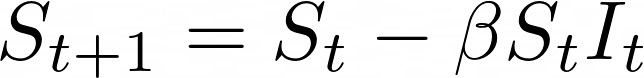

In [18]:
from IPython.display import Image
IMAGE_PATH = '../../../skema/im2mml/generate_mathml/images/sir.png'
Image(filename=IMAGE_PATH) 

The presentation MathML representation of the above equation is shown below.

In [19]:
content = \
"""<math 
    xmlns="http://www.w3.org/1998/Math/MathML" 
    display="block" 
    title="S_{t+1} = S_t - \beta S_t I_t "
>
  <mrow>
    <msub>
      <mrow>
        <mi>S</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
        <mo>+</mo>
        <mn>1</mn>
      </mrow>
    </msub>
    <mo>=</mo>
    <msub>
      <mrow>
        <mi>S</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
      </mrow>
    </msub>
    <mo>-</mo>
    <mi>β</mi>
    <msub>
      <mrow>
        <mi>S</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
      </mrow>
    </msub>
    <msub>
      <mrow>
        <mi>I</mi>
      </mrow>
      <mrow>
        <mi>t</mi>
      </mrow>
    </msub>
  </mrow>
</math>"""

We can visualize the abstract syntax tree of the above MathML document using our REST API, which returns a DOT representation for visualization.

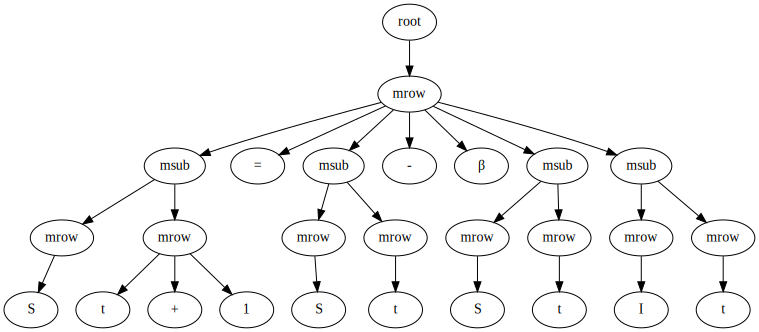

In [20]:
Source(
    put('http://localhost:8080/mathml/ast-graph',
        data=content.encode('utf-8')).text
)

However, the presentation MathML representation is only concerned with the *presentation* of the equation, rather than the *content*. In order to work with the semantic content of the equation, we must transform the presentation MathML representation into a semantically meaningful representation, using a set of heuristic rules. We call this representation the 'math expression graph' (MEG). We may come up with a better name for it later...

In the cell below, we send a MathML document to the `/mathml/math-exp-graph` which automatically constructs the MEG and returns a DOT representation of it for visualization.

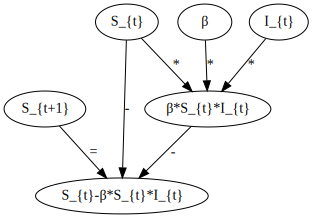

In [21]:
Source(
    put(
        'http://localhost:8080/mathml/math-exp-graph',
        data=content.encode('utf-8')).text
)

The representation shown above encodes the semantic content of the MathML equation in a compact fashion, making it more suitable for alignment with code.